In [1]:
def memit_parser(std):
    # This function parses the output of the memory_profiler module
    std = str(std)
    return std.split(" ")[2]

In [2]:
%load_ext memory_profiler 
mu_key_generation = %memit -o from ET_ContextGenerator import key_context as context
mu_key_generation = memit_parser(mu_key_generation)


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Is the context private? Yes
Automatic relinearization is: on
Automatic rescaling is: on
Automatic modulus switching is: on
peak memory: 3485.93 MiB, increment: 3384.55 MiB


In [3]:
import os
dir = os.getcwd()
if dir.split("/")[-3] == "codebase":
    os.chdir("../../")


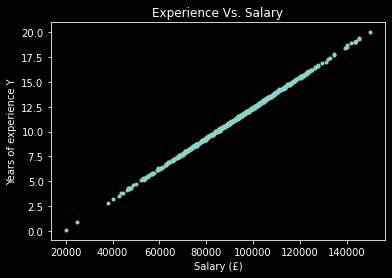

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tenseal as ts
import time
import dataset_generator as dg  # Import dataset_generator.py


In [5]:
# importing module
from csv_logger import CsvLogger
import logging

filename = f"./ET_Log/Sample:{dg.n_samples}|Noise:{dg.noise}.csv"
delimiter = ","
level = logging.INFO
fmt = f"%(asctime)s{delimiter}%(levelname)s{delimiter}%(message)s"
datefmt = "%Y/%m/%d %H:%M:%S"
level = logging.INFO
header = [
    "Date",
    "Level",
    "Final Loss",
    "Degree of accuracy (Decimal place)",
    "Encrypted test accuracy",
    "Average duration per epoch",
    "Memory of model",
    "Memory usage of Encrypting X axis train set",
    "Memory usage of Encrypting Y axis train set",
    "Memory usage of Key generation"
]
csvlogger = CsvLogger(
    filename=filename,
    delimiter=delimiter,
    level=level,
    fmt=fmt,
    datefmt=datefmt,
    header=header,
)


In [6]:
torch.random.manual_seed(10)


## PyTorch Linear regression model

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out


## Custom encrypted wrapper
This HE handler is adapted from https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%201%20-%20Training%20and%20Evaluation%20of%20Logistic%20Regression%20on%20Encrypted%20Data.ipynb

In [8]:
class EncryptedLinReg:
    def __init__(self, torch_lr, context):
        self.weight = torch_lr.linear.weight.data.tolist()[0]
        self.bias = torch_lr.linear.bias.data.tolist()
        self.decimal_accuracy = -1
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        self.out_minus_y = enc_out - enc_y  #Loss value Since we were using Mean Absolute Error for the PT model
        print(
            f"Loss for iteration is {sum(abs(number) for number in self.out_minus_y.decrypt())}"
        )
        ## SGD
        self._delta_w += 1 / (self._count + 1) * (enc_x * self.out_minus_y) ** 2
        self._delta_b += self.out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights and bias
        self.weight -= self._delta_w * (1 / self._count) + self.weight
        self.bias -= self._delta_b * (1 / self._count)
        
        #Reset gradient accumulators and iterations count for the next iteration
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def clip_gradient(self, context):
        """Implement gradient cliping by norm
        This will decrypt weight and clip the gradient via the norm

        Args:
            context (TensealContext): TensealContext object used to encrypt the weights again
        """
        threshold = 0.2
        if type(self.weight) == ts.CKKSVector:
            ct_weight = self.weight.decrypt()
            norm = np.linalg.norm(ct_weight)
            if norm > threshold or norm < -threshold:
                ct_weight = [weight * threshold / norm for weight in ct_weight]
                self.weight = ts.ckks_vector(context, ct_weight)
        else:
            pt_weight = self.weight
            norm = np.linalg.norm(pt_weight)
            if norm > threshold or norm < -threshold:
                self.weight = [weight * threshold / norm for weight in pt_weight]

        # eelr.clip_delta_gradient(self.context)

    def clip_delta_gradient(self, context):
        """Implement gradient cliping by norm
        This will decrypt weight and clip the delta gradient via the norm

        Args:
            context (TensealContext): TensealContext object used to encrypt the weights again
        """
        threshold = 0.2
        if type(self._delta_w) == ts.CKKSVector:
            ct_weight = self._delta_w.decrypt()
            norm = np.linalg.norm(ct_weight)
            if norm > threshold or norm < -threshold:
                ct_weight = [weight * threshold / norm for weight in ct_weight]
                self._delta_w = ts.ckks_vector(context, ct_weight)
        else:
            pt_weight = self._delta_w
            norm = np.linalg.norm(pt_weight)
            if norm > threshold or norm < -threshold:
                self._delta_w = [weight * threshold / norm for weight in pt_weight]

    def plain_accuracy(self, x_test, y_test):
        #Test the model
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = (x_test.matmul(w) + b).reshape(-1, 1)
        with torch.no_grad():  # no need to calculate gradients for testing
            y_pred_experience = torch.round(
                out, decimals=self.decimal_accuracy
            )  # Predicited result: nearest year experience rounded to whole number
            y_real_rounded = torch.round(
                y_test, decimals=self.decimal_accuracy
            ) # Actual result: nearest year experience rounded to whole number
            accuracy = torch.eq(y_pred_experience, y_real_rounded)
        return torch.sum(accuracy).item() / len(accuracy) * 100 #Accuracy in percentage

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [9]:
def test_train_split(df):
    training_data = df.sample(frac=0.5, random_state=25)  #50/50 split for simplicity of the model
    testing_data = df.drop(training_data.index)
    y_train, x_train = (
        training_data["YearsExperience"].to_numpy(),
        training_data["Salary"].to_numpy(),
    )
    y_test, x_test = (
        testing_data["YearsExperience"].to_numpy(),
        testing_data["Salary"].to_numpy(),
    )
    return x_train, y_train, x_test, y_test


In [10]:
df = pd.read_csv("./LinearRegression/Data/Custom_Salary_Data.csv")

x_train, y_train, x_test, y_test = test_train_split(df)

#Preparing dataset
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


x_train_tensor = torch.from_numpy(x_train).double().requires_grad_()
y_train_tensor = torch.from_numpy(y_train).double().requires_grad_()

x_test_tensor = torch.from_numpy(x_test).double()
y_test_tensor = torch.from_numpy(y_test).double()

#Measure memory usage of encrypting the dataset
mu_enc_x_train=  %memit -o enc_x_train = ts.ckks_vector(context, x_train.flatten())
mu_enc_x_train = memit_parser(mu_enc_x_train)
mu_enc_y_train = %memit -o enc_y_train = ts.ckks_vector(context, y_train.flatten())
mu_enc_y_train = memit_parser(mu_enc_y_train)

peak memory: 3702.77 MiB, increment: 12.78 MiB
peak memory: 3706.70 MiB, increment: 3.93 MiB


In [11]:
#Initialise the Weights and biases
eelr = EncryptedLinReg(LinearRegressionModel(1, 1), context)
eelr.clip_gradient(context)

# Initate the weights and biases with test data
accuracy = eelr.plain_accuracy(x_test_tensor.float(), y_test_tensor.float())
print(f"Accuracy at epoch #0 is {accuracy}")

EPOCHS = 50

global times
times = []


def train(context, enc_x_train, enc_y_train, eelr):
    for epoch in range(EPOCHS):
        start = time.time()
        # Encrypt the weights and biases
        eelr.encrypt(context)
        # Run forward pass
        enc_out = eelr.forward(enc_x_train)
        # Run backward pass
        eelr.backward(enc_x_train, enc_out, enc_y_train)
        
        #Clip the delta gradient, requires decrypting the weights which will be sent back to the data owner
        #The data owner will decrypt the weights clip it and send it back to the client
        eelr.clip_delta_gradient(context)
        
        # Update the weights and biases
        eelr.update_parameters()
        
        #Clip the gradient, requires decrypting the weights which will be sent back to the data owner
        #The data owner will decrypt the weights clip it and send it back to the client
        eelr.clip_gradient(context)

        #Decrypt the weights and biases to test, in reality this will be sent back to the owner of the data
        #where they'll decrypt the weights and biases and return it back to the server, in reality this will be minimal. Since it will result in a few kilobytes of commmunication per epoch.
        eelr.decrypt()
        
        #Test the model
        accuracy = eelr.plain_accuracy(
            x_test_tensor.float().flatten(), y_test_tensor.float()
        )
        print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")
        times.append(time.time() - start)

    return accuracy


decimal_accuracy = eelr .decimal_accuracy
#Test memory usage of the model
mu_model_and_accuracy_test = %memit -o accuracy = train(context, enc_x_train, enc_y_train, eelr)
mu_model_and_accuracy_test = memit_parser(mu_model_and_accuracy_test)
print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")


Accuracy at epoch #0 is 0.0
Loss for iteration is 431951553.4939409
Accuracy at epoch #1 is 0.0
Loss for iteration is 362701562.92831016
Accuracy at epoch #2 is 0.0
Loss for iteration is 3785709.806138874
Accuracy at epoch #3 is 0.0
Loss for iteration is 33464.17673041919
Accuracy at epoch #4 is 0.0
Loss for iteration is 14190.612972981005
Accuracy at epoch #5 is 0.0
Loss for iteration is 147470814.52209246
Accuracy at epoch #6 is 0.0
Loss for iteration is 148992224.55978626
Accuracy at epoch #7 is 0.0
Loss for iteration is 1530966.239482058
Accuracy at epoch #8 is 0.0
Loss for iteration is 29940.032561251515
Accuracy at epoch #9 is 0.0
Loss for iteration is 9736.181861421646
Accuracy at epoch #10 is 0.0
Loss for iteration is 147463749.68745568
Accuracy at epoch #11 is 0.0
Loss for iteration is 148968186.32066205
Accuracy at epoch #12 is 0.0
Loss for iteration is 1494324.9883960884
Accuracy at epoch #13 is 0.0
Loss for iteration is 14318.134161848575
Accuracy at epoch #14 is 0.0
Loss f

In [12]:
csvlogger.info(
    f"{sum(abs(number) for number in eelr.out_minus_y.decrypt())}, {decimal_accuracy}, {accuracy}, {int(sum(times) / len(times))} , {mu_model_and_accuracy_test}, {mu_enc_x_train} ,{mu_enc_y_train}, {mu_key_generation}"
)
print(
    f"{sum(abs(number) for number in eelr.out_minus_y.decrypt())}, {decimal_accuracy}, {accuracy}, {int(sum(times) / len(times))} , {mu_model_and_accuracy_test}, {mu_enc_x_train} ,{mu_enc_y_train}, {mu_key_generation}"
)

1512542.013011971, -1, 0.0, 2 , 3848.24, 3702.77 ,3706.70, 3485.93
